# Eigenfaces

Reference: https://github.com/svetlana-topalova/eigenfaces/blob/master/Eigenfaces.ipynb

In [44]:
%matplotlib inline

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### 1. Read Images

Reading every image within a directory, and converting them into numpy arrays.

In [45]:
IMAGE_DIR = 'old_faces'
DEFAULT_SIZE = [180, 225]

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_files = [image for image in os.listdir(image_path)]
        
    for image_file in image_files:
        image = Image.open(os.path.join(image_path, image_file))
        image = image.convert('L')
        
        if default_size is not None:
            image = image.resize(default_size, Image.ANTIALIAS)
        
        images.append(np.asarray(image, dtype=np.uint8))
        images_names.append(image_file[0:-4])

    return [images, images_names]

### Assemble Data Matrix

Represent every image as a vector.

In [46]:
# Each row of the data matrix is one image.

def as_row_matrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((0, X[0].size), dtype=X[0].dtype)
    for row in X:
        mat = np.vstack((mat, np.asarray(row).reshape(1, -1))) # 1 x r*c
    return mat

### Compute the mean face $\mu$

The average of the image set is calculated as:

<img src="resources/compute_mean_face.png" />

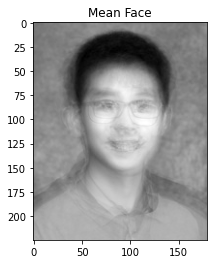

In [47]:
[X, y] = read_images()
average_weight_matrix = np.reshape(as_row_matrix(X).mean(axis=0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title('Mean Face')
plt.show()

### Calculate PCA (Principal Component Analysis)

Calculation includes two steps:
1. Subtract the mean. The average image a has to be subtracted from each original image in X.
2. Calculate the eigenvectors and eigenvalues of the covariance

<img src="resources/avg_sub.png" />

<img src="resources/covariance_calculated.png" />

These eigenvectors have the same dimensionality (number of components) as the original images, thus can be viewed as an image.

3. Choose the principal components

Sorting the eigenvalues with `np.argsort` in descending order and arrange eigenvectors accordingly. We find `k` useful eigenfaces, where k is the smallest number that satisfies: <img src="resources/k_smallest.png" />

We use `get_number_of_components_to_preserve_variance` to calculate that.

The `k` principal components of the observed vector `x` are then given by:
<img src="resources/vector_x.png" />
where
<img src="resources/where.png" />

In [48]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.99):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii
        
def pca(X, y, num_components=0):
    [n, d] = X.shape
    
    if num_components <= 0 or num_components > n:
        num_components = n
        mu = X.mean(axis=0)
        X = X - mu
    
    if n > d:
        C = np.dot(X.T, X) # Covariance matrix
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X, X.T) # Covariance matrix
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors)
        
        for i in range(n):
            eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])
    
    # Sort eigenvectors in descending order by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    
    # Select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:, 0:num_components].copy()
    
    return [eigenvalues, eigenvectors, mu]

[eigenvalues, eigenvectors, mean] = pca(as_row_matrix(X), y)

Eigenfaces with the highest eigenvalues are calculated using the training set. They are called the ghost faces. The sharpness of these ghost faces depends on the backgrounds and the other details of the images.

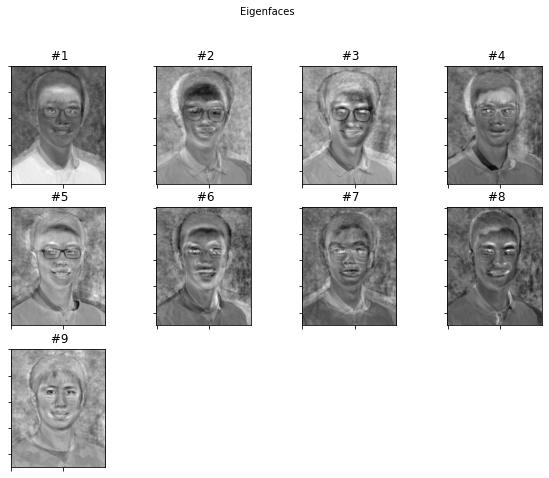

In [49]:
def subplot(title, images, rows, cols, sptitle='', sptitles=[], colormap=plt.cm.gray, filename=None, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    
    # Main title
    fig.text(.5, .95, title, horizontalalignment='center')
    
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows, cols, (i + 1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(sptitles) == len(images):
            plt.title('%s #%s' % (sptitle, str(sptitles[i])))
        else:
            plt.title('%s #%d' % (sptitle, i + 1))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    
    if filename is None:
        plt.show()
    else:
        fig.savefig(filename)

E = []
number = eigenvectors.shape[1]
for i in range(min(number, 16)):
    e = eigenvectors[:, i].reshape(X[0].shape)
    E.append(np.asarray(e))

# Plot them and store the plot to 'python_eigenfaces.pdf'
subplot(title='Eigenfaces', images=E, rows=4, cols=4, colormap=plt.cm.gray, filename='python_pca_eigenfaces.png')

Cumulative sum of first highest eigenvalues is given below. Based on the plot it's clear we should pick these features.

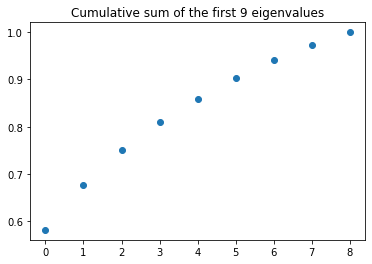

In [50]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title('Cumulative sum of the first {0} eigenvalues'.format(number))
plt.show()

### Representing faces onto this basis


Each face can be represented as a linear componation of the eigenfaces. Each face can also be estimated using the "best" eigenfaces, which have the largest eigenvalues and represent the largest variations in the face image database.

The reconstruction of PCA basis is given by:

<img src="resources/avg_sub.png" />

where

<img src="resources/svi_equals.png" />

#### Example
<img src="resources/n_over_v.png" />

### Face Recognition using Eigenfaces

In an unknown image, an eigenface is formed for the given image, and the Euclidian distances between this eigenface and the previously stored eigenfaces are calculated. The eigenface with the smallest distance is the one the person resembles the most.

Face recognition performed by:
1. Projecting all training samples into the PCA subspace.
2. Projecting the query image into the PCA subspace.
3. Finding the nearest neighbor between the projected training images and the projected queryimage.

The Euclidean distance between points p and q is the length of the line segment connecting them.
<img src="resources/avg_sub.png" />

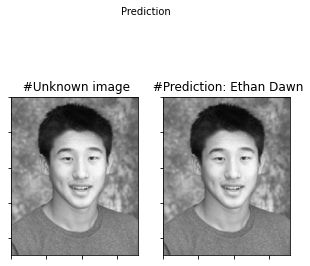

In [51]:
def project(W , X, mu):
    return np.dot(X - mu , W)

def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    
    return np.sqrt(np.sum(np.power((p-q), 2)))

def predict(W, mu, projections, y, X):
    min_dist = float('inf')
    min_class = -1
    Q = project(W, X.reshape(1 , -1), mu)
    
    for i in range(len(projections)):
        dist = dist_metric(projections[i], Q)
        if dist < min_dist:
            min_dist = dist
            min_class = i
            
    return min_class

projections = []
for xi in X:
    projections.append(project(eigenvectors, xi.reshape(1, -1), mean))

image = Image.open('old_faces/Ethan Dawn.jpg')
image = image.convert('L')

if DEFAULT_SIZE is not None :
    image = image.resize(DEFAULT_SIZE, Image.ANTIALIAS )
    
test_image = np.asarray(image, dtype=np.uint8 )
predicted = predict(eigenvectors, mean, projections, y, test_image)

subplot (title='Prediction', images=[test_image, X[predicted]], rows=1, cols=2, 
         sptitles=['Unknown image', 'Prediction: {0}'.format(y[predicted])], colormap=plt.cm.gray , 
         filename='prediction_test.png', figsize=(5,5))

## Least-Squares

Below, I used these two formulas to calculate the least-square weights, then I weighted the eigenfaces using the weights calculated and generated a list of new faces.

$A{x} = {b}$

$x=(A^{T}A)^{-1}A^{T}{b}$

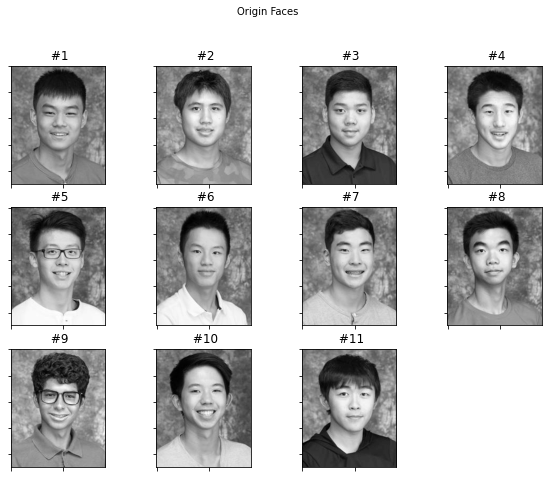

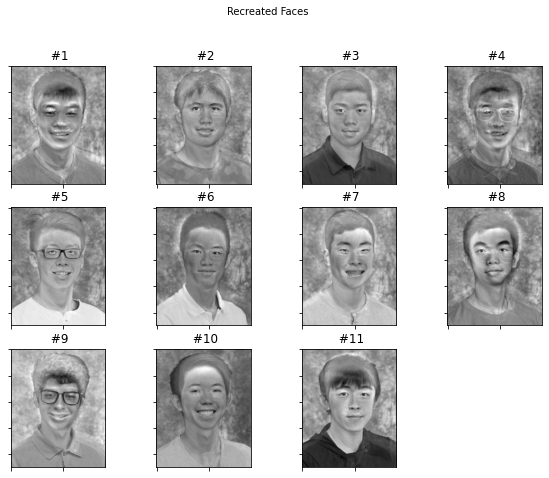

In [52]:
recreated_faces = []
b_hats = []

for b in as_row_matrix(X):
    x = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(eigenvectors), eigenvectors)), np.transpose(eigenvectors)), b-mean)
    
    b_hat = np.matmul(eigenvectors, x)
    b_hats.append(b_hat)
    
    face = b_hat.reshape(X[0].shape)
    recreated_faces.append(face)
    
subplot(title='Origin Faces', images=X, rows=4, cols=4, colormap=plt.cm.gray)
subplot(title='Recreated Faces', images=recreated_faces, rows=4, cols=4, colormap=plt.cm.gray, filename='recreated_faces.png')

## Gram-Schmidt

Given a basis ${X_1, ..., X_p}$ for a subspace $W$ of $R^n$ define

$v_1 = x_1$

$v_2 = x_2 - (\frac{x_2*v_1}{v_1*v_1})v_1$

$v_3 = x_3 - (\frac{x_3*v_1}{v_1*v_1})v_1 - (\frac{x_3*v_2}{v_2*v_2})v_1$

$v_{p}=x_{p}-\sum_{k=1}^{p-1}(\frac{x_p.v_k}{v_k.v_k})v_k$

Then $\{v_1,...,v_p\}$ is an orthogonal basis for $W$.

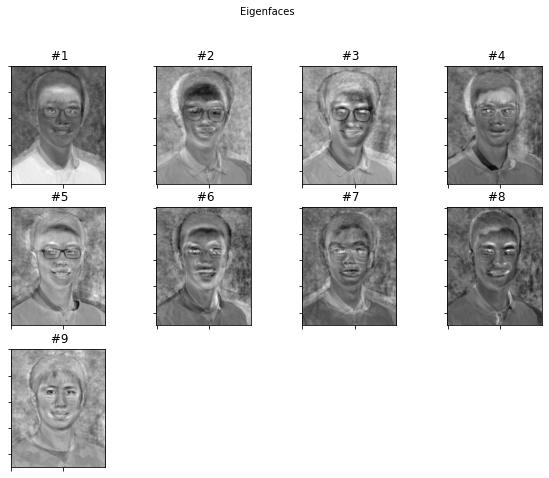

In [53]:
v = []
E = []
x = np.transpose(eigenvectors)

for p in range(len(x)):
    vp = x[p]
    for k in range(p):
        vp -= (np.dot(x[p], v[k]) / np.dot(v[k], v[k])) * v[k]
    v.append(vp)

v = np.transpose(np.asarray(v))
number = v.shape[1]

for i in range(min(number, 16)):
    e = v[:, i].reshape(X[0].shape)
    E.append(np.asarray(e))
    
subplot(title='Eigenfaces', images=E, rows=4, cols=4, colormap=plt.cm.gray, filename='orthogonalized_eigenfaces.png')

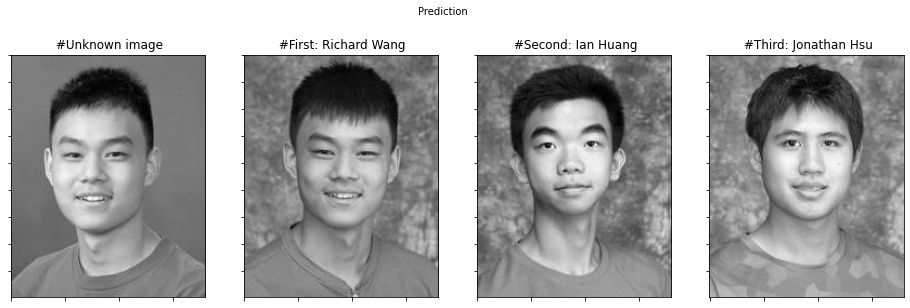

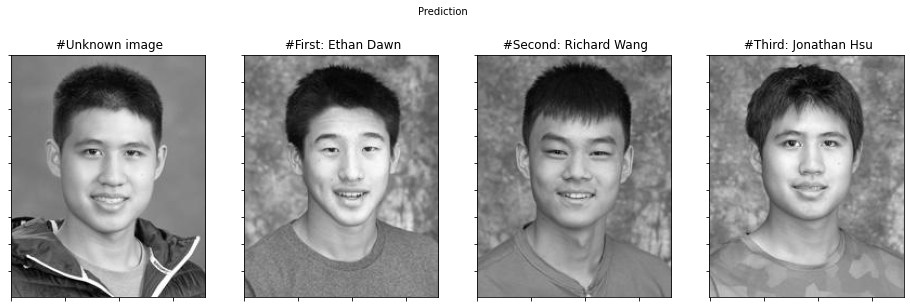

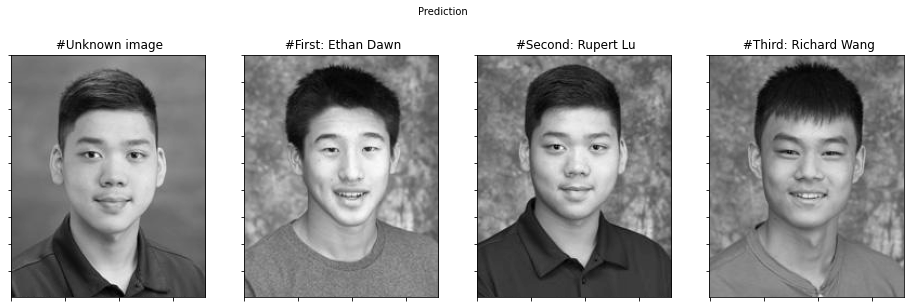

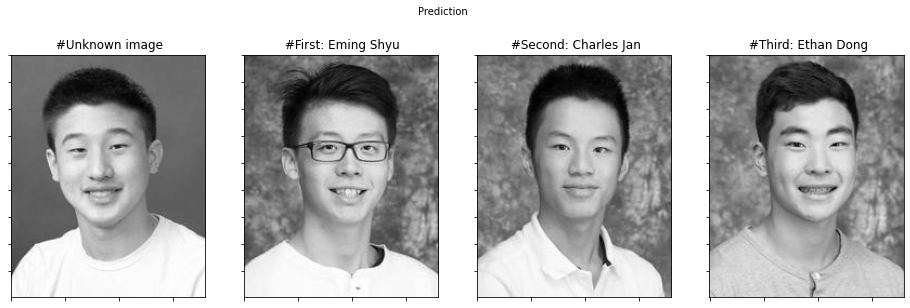

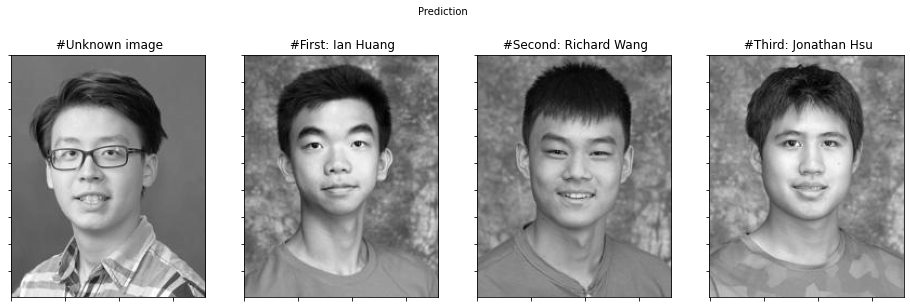

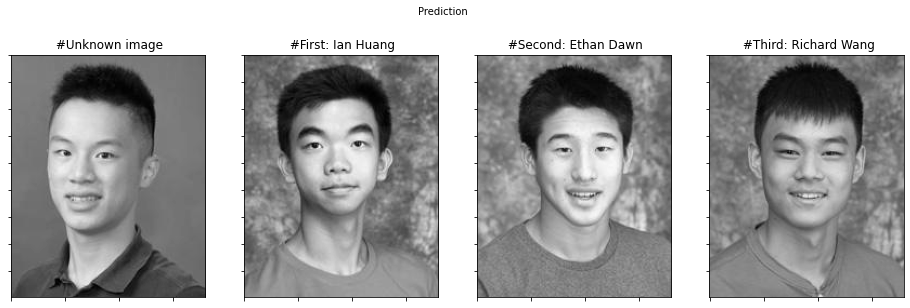

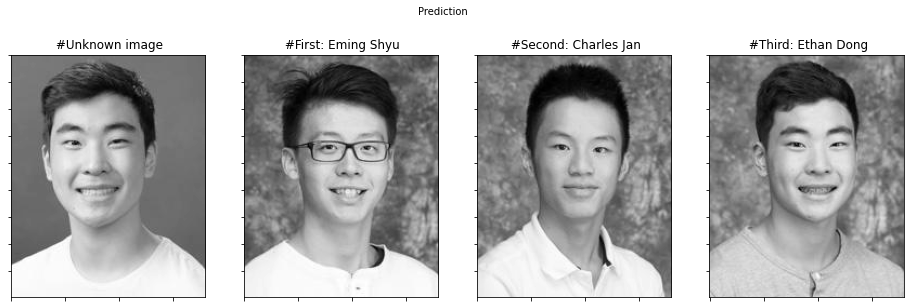

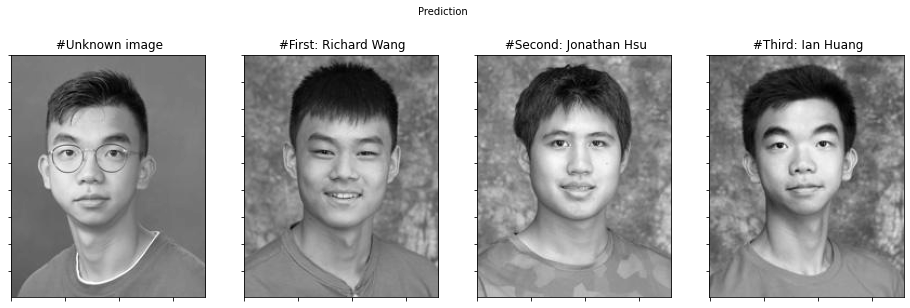

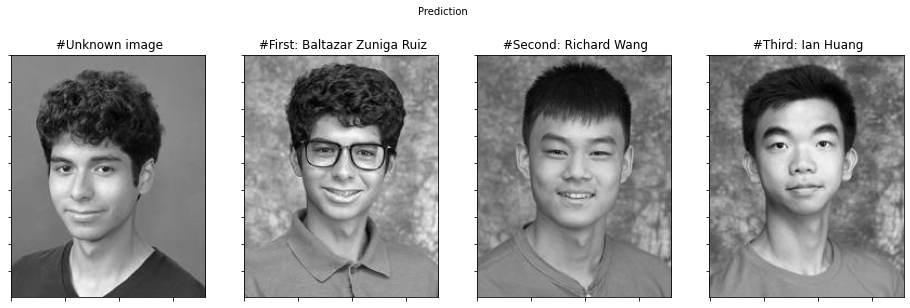

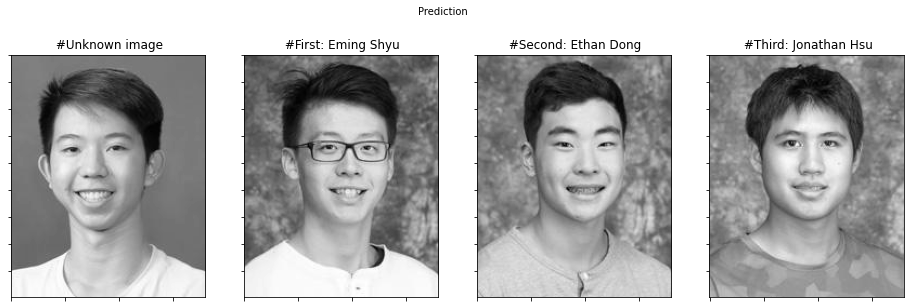

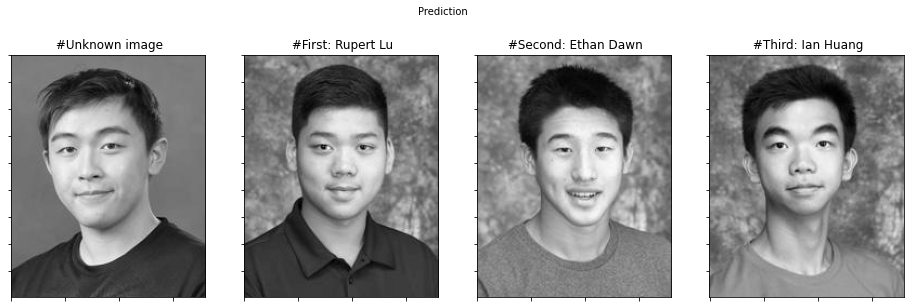

In [75]:
def project(b, eigenvectors):
    # Second formula of least squares
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(eigenvectors), eigenvectors)), np.transpose(eigenvectors)), b)

def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    
    return np.sqrt(np.sum(np.power((p-q), 2)))

def predict(W, projections, y, b):
    min_dist = float('inf')
    min_class = -1
    Q = project(b, v)
    
    ranks = []
    
    for i in range(len(projections)):
        dist = dist_metric(projections[i], Q)
        ranks.append((dist, i))
    
    ranks.sort(key=lambda x:x[0])
    
    return [rank[1] for rank in ranks[0:3]]

projections = []
for b in as_row_matrix(X):
    projections.append(project(b - mean, v))

[X_tests, y_tests] = read_images(image_path='new_faces')

for i in range(len(X_tests)):
    [first, second, third] = predict(eigenvectors, projections, y, X_tests[i].reshape(-1) - mean)
    subplot(title='Prediction', images=[X_tests[i], X[first], X[second], X[third]], rows=1, cols=4, sptitles=['Unknown image', f'First: {y[first]}', f'Second: {y[second]}', f'Third: {y[third]}'], colormap=plt.cm.gray, filename=f'predictions/prediction_{i}.png', figsize=(16, 5))

# @Baltazar helped me a lot for this part ^^^^